# Autoencoder for Clump Finding in Low dimension
> Created Nov. 2024 <br>
> Nikhil Bisht<br>

# Functions and Definitions

In [53]:
# standard system modules
import os, sys
import h5py 
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import xgboost as xgb

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

In [54]:
DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_Initial_Final_AutoEnc.csv'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
DATAFILE_CORES  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset.csv'
MODELFILE = 'nnmodel.dict'

NTRAIN = 1600000
NVALID =  100000 #roughly
NTEST  =  300000 

TARGET = ['Vx_f', 'Vy_f', 'Vz_f','Density_f']
POS_FEAT = ['X_f', 'Y_f', 'Z_f','X_i', 'Y_i', 'Z_i']
FEATURES = ['Vx_i', 'Vy_i', 'Vz_i','Density_i']
CORE_FEATURES = ['O_Clump_X', 'O_Clump_Y',	'O_Clump_Z', 'O_Clump_Vx', 'O_Clump_Vy', 'O_Clump_Vz', 'O_Clump_density']
TRACER_FEATURES = ['Clump_id', 'X', 'Y', 'Z', 'Vx', 'Vy', 'Vz','Density']

n_input = len(FEATURES)
n_output = len(TARGET)

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')
print(n_input, n_output)

Available device: cpu 
4 4


In [55]:
def plot_colors(data, fname,
                ftsize=14):
    import corner
    
    # set size of figure
    fig = plt.figure(figsize=(4, 4))
    if fname[0] =='t':
        labels=[r"$X_f$",r"$Y_f$",r"$Z_f$",r"$Vx_f$", r"$Vy_f$",r"$Vz_f$",r"$Density_f$"]
    if fname[0] =='I':
        labels=[r"$X_i$",r"$Y_i$",r"$Z_i$",r"$Vx_i$", r"$Vy_i$",r"$Vz_i$",r"$Density_i$"]
    fig = corner.corner(
        data,
        labels = labels,
    figsize=(2, 2),
    #quantiles=[0.16, 0.5, 0.84],
    #show_titles=True,
    title_kwargs={"fontsize": 18},
    label_kwargs={"fontsize": 20},
    hist_kwargs={"color": "blue", 
                 "linewidth": 4,
                 "facecolor": "c"}
    );

    fig.tight_layout()
    
    plt.savefig(fname)
    
    plt.show()

In [56]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class AutoEncoder(nn.Module):
    
    def __init__(self, encoder, decoder):
        # call constructor of base (or super, or parent) class
        super(AutoEncoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y
        

In [57]:
def get_random_batch(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]
def train(model, optimizer, getbatch, loss_fn, train_x, batch_size):
    
    model.train()

    # get a batch of training data
    x = getbatch(train_x, batch_size)
    
    # compute model
    pred_x = model(x)

    # compute loss functions, given the model outputs and the targets
    loss = loss_fn(pred_x, x)
    
    optimizer.zero_grad()  # clear previous gradients
    
    loss.backward()        # compute gradients
    
    optimizer.step()       # move one step
        
def validate(model, loss_fn, train_x, valid_x):
    
    n_valid = len(valid_x)
    
    model.eval()
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, t

        # compute model
        pred_x = model(train_x[:n_valid])
        loss_t = loss_fn(pred_x, train_x[:n_valid]).data.cpu()

        pred_x = model(valid_x)
        loss_v = loss_fn(pred_x, valid_x).data.cpu()

    return loss_t, loss_v
               
def trainModel(model, optimizer, getbatch, averageloss, modelfile,
               train_x, valid_x, 
               n_iterations, batch_size, 
               xx=[], yy_t=[], yy_v=[], step=100):

    min_loss_v = 1e30
    print('%10s\t%10s\t%10s' % ('iteration', 'training', 'validation'))
    
    for ii in range(n_iterations):
        
        train(model, optimizer, getbatch, averageloss, train_x, batch_size)

        if ii % step == 0:
            
            loss_t, loss_v = validate(model, averageloss, train_x, valid_x)
            
            print("\r%10d\t%10.6f\t%10.6f" % (ii, loss_t, loss_v), end='')

            if len(xx) < 1:
                xx.append(0)
            else:
                xx.append(xx[-1]+step)
            yy_t.append(loss_t)
            yy_v.append(loss_v)
            
        if loss_v < min_loss_v:
            min_loss_v = loss_v
            torch.save(model.state_dict(), modelfile)
            
    print()
    return xx, yy_t, yy_v
def plot_loss(x, y_t, y_v):
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Training and Validation Loss', fontsize=16)

    # axis limits
    ax.set_xlim((x[0], x[-1]))
    ax.set_xlabel('Iterations', fontsize=14)
    
    ax.set_ylabel('loss', fontsize=14)
    ax.set_yscale('log')
    
    ax.plot(x, y_t, 'b', label='Training')
    ax.plot(x, y_v, 'r', label='Validation')

    ax.grid(True, which="both", linestyle='-')

    ax.legend(loc='upper right')
    
    fig.tight_layout()
    plt.savefig('loss.png')
    plt.show()

In [58]:
def normalize_latent_space(z):
    # normalize latent space
    z1, z2 = z.transpose(0, 1)

    norm1 = nn.LayerNorm(z1.shape)
    z1 = norm1(z1).detach().numpy()

    norm2 = nn.LayerNorm(z2.shape)
    z2 = norm2(z2).detach().numpy()
    return z1, z2

def plot_latent_2d(z1, z2,
                filename='latent_space_2d.png', coredata = []):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Latent Space 2D', fontsize=16)

    # axis limits
    ax.set_xlabel('$z_1$', fontsize=14)

    ax.set_ylabel('$z_2$', fontsize=14)

    # plot data in latent space
    ax.scatter(z1, z2, color='blue', s=0.005)
        
    # histogram latent space 
    p, x, y = np.histogram2d(z1, z2, 
                             bins=(30, 30))
    # Note: must transpose the p 2D array
    p = p.T / p.max()
    
    # compute bin centers
    x = (x[:-1] + x[1:])/2
    y = (y[:-1] + y[1:])/2
    
    # construct a meshgrid, that is, arrays x and y such that (x[i], y[i])
    # are the coordinates of the bin centers.
    x, y = np.meshgrid(x, y)

    mylevels = [0.1, 0.2, 0.5, 1]
    cs = plt.contour(x, y, p, cmap='rainbow_r', levels=mylevels)

    if coredata!=[]:
        sct = plt.scatter(coredata[0],coredata[1], color='black', s=50, marker='*', zorder=100)

    ax.grid()
    
    fig.tight_layout()
    
    plt.savefig(filename)
    
    plt.show()

def plot_latent_1d(z1,
                filename='latent_space_1d.png', coredata = []):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Latent Space 1D', fontsize=16)

    # axis limits
    ax.set_xlabel('$z_1$', fontsize=14)


    # plot data in latent space
        
    # histogram latent space 
    p = plt.hist(z1.detach().numpy(), bins=1000)

    if coredata!=[]:
        for lineval in coredata[0].detach().numpy()[::10]:
            sct = plt.axvline(lineval, color='black')
    
    ax.grid()
    
    fig.tight_layout()
    
    plt.savefig(filename)
    
    plt.show()

# Load Sample

In [59]:
df = pd.read_csv(DATAFILE)
df['Particle_id'] = df['Particle_id'].astype('int32')
print(len(df))
#df = df.sample(frac=1).reset_index(drop=True)

#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#Now we split regular and anomalies
df_mean = df.mean()
df_std = df.std()
anomalous_dataset = df.loc[df['Particle_id'].isin(df_core_pids)][TARGET]
df = df.drop(df[df['Particle_id'].isin(df_core_pids)].index)
print(len(df))
df.head()

2097152
1979788


,Unnamed: 0,Particle_id,X_i,Y_i,Z_i,Vx_i,Vy_i,Vz_i,Density_i,X_f,Y_f,Z_f,Vx_f,Vy_f,Vz_f,Density_f
0,0,0,0.003906,0.003906,0.003906,-0.062886,0.171087,-0.070687,0.524400,0.420833,0.396885,0.014218,0.057286,1.680171,3.215259,2.120459
1,1,1,0.011719,0.003906,0.003906,-0.055288,0.180062,-0.074365,0.317997,0.423090,0.397287,0.003344,-0.140619,2.060933,3.139795,1.332378
2,2,2,0.019531,0.003906,0.003906,-0.047587,0.188767,-0.077728,0.447816,0.423268,0.397211,0.008459,0.013957,1.976570,3.124281,1.542812
3,3,3,0.027344,0.003906,0.003906,-0.039801,0.197138,-0.080742,0.582043,0.481153,0.342499,0.038346,-1.085764,4.840790,3.348466,0.213836
4,4,4,0.035156,0.003906,0.003906,-0.031951,0.205112,-0.083371,0.331791,0.401509,0.403064,0.003883,-0.726529,1.547427,3.059141,4.949259


In [9]:
# split and convert to tensors
normalized_df=(df-df_mean)/df_std #rescaled (maybe take log of density)
normalized_df[POS_FEAT] = df[POS_FEAT]
anomalous_dataset_normed=(anomalous_dataset-df_mean)/df_std

data = normalized_df[TARGET].to_numpy() 
anomalous_data = anomalous_dataset_normed[TARGET].to_numpy() 
train_x, X = torch.Tensor(data[:NTRAIN]),  data[NTRAIN:]
test_x, valid_x = torch.Tensor(X[:NTEST]), torch.Tensor(X[NTEST:])

all_data = torch.Tensor(data)
# do the same for initial conditions
Initial_data = torch.Tensor(normalized_df[FEATURES].to_numpy())

#and get core data
Core_data = torch.Tensor(anomalous_data)
plot_colors(test_x.detach().numpy(), fname = 'test_data_correlation.png')
plot_colors(Initial_data, 'Initial_data_correlation')

In [62]:
# split and convert to tensors
normalized_df=(df-df_mean)/df_std #rescaled (maybe take log of density)
normalized_df[POS_FEAT] = df[POS_FEAT]
anomalous_dataset_normed=(anomalous_dataset-df_mean)/df_std

data = normalized_df[TARGET].to_numpy() 
anomalous_data = anomalous_dataset_normed[TARGET].to_numpy() 
train_x, X = torch.Tensor(anomalous_data[:90000]),  anomalous_data[90000:]
test_x, valid_x = torch.Tensor(X[:10000]), torch.Tensor(X[10000:])

all_data = torch.Tensor(data)
# do the same for initial conditions
Initial_data = torch.Tensor(normalized_df[FEATURES].to_numpy())

#and get core data
Core_data = torch.Tensor(anomalous_data)
#plot_colors(test_x.detach().numpy(), fname = 'test_data_correlation.png')
#plot_colors(Initial_data, 'Initial_data_correlation')

In [17]:
normalized_df[TARGET].head()

,Vx_f,Vy_f,Vz_f,Density_f
0,0.029834,0.117462,1.024884,-0.128056
1,-0.020873,0.208526,1.006268,-0.128056
2,0.018732,0.188350,1.002441,-0.128056
3,-0.263034,0.873363,1.057745,-0.128057
4,-0.170992,0.085715,0.986371,-0.128053


In [18]:
anomalous_dataset_normed[TARGET].head()

,Vx_f,Vy_f,Vz_f,Density_f
1488,-1.440981,0.655901,-0.179642,-0.128056
1489,-0.560328,-0.417409,-0.464269,-0.128056
1490,-0.854474,-0.112082,0.152018,-0.128056
1551,-0.280623,0.734127,0.722419,-0.128057
1552,-1.482085,1.237402,0.109737,-0.128055


In [63]:
H_NODES = 40

encoder = nn.Sequential(
    nn.Linear(n_input, 3), nn.SiLU(), nn.LayerNorm(3),
    #nn.Linear(6, 5), nn.SiLU(), nn.LayerNorm(5), 
    #nn.Linear(5, 4), nn.SiLU(), nn.LayerNorm(4),
    nn.Linear(3, 2), nn.SiLU(), nn.LayerNorm(2), 
    nn.Linear(2, 1), 
        )

decoder = nn.Sequential(
    nn.Linear(      1, 2), nn.SiLU(), nn.LayerNorm(2),
    nn.Linear(2, 3), nn.SiLU(), nn.LayerNorm(3),
    #nn.Linear(4, 5), nn.SiLU(), nn.LayerNorm(5),
    #nn.Linear(5, 6), nn.SiLU(), nn.LayerNorm(6),
    nn.Linear(3, n_input)
        )

model = AutoEncoder(encoder, decoder)
print('number of parameters:', number_of_parameters(model))

number of parameters: 75


 iteration	  training	validation
     19900	  0.365028	  1.459998

done!


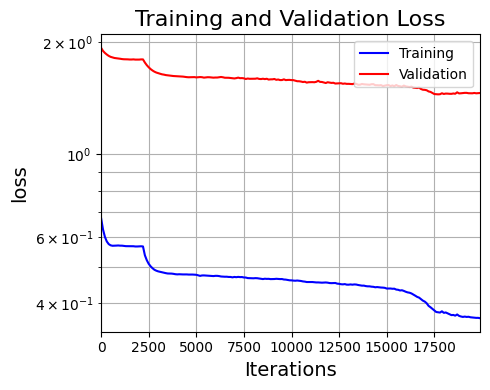

In [64]:
xx   = []  # iteration numbers
yy_t = []  # prediction accuracy using training data
yy_v = []  # prediction accuracy using validation data
n_iter  = 20000    # number of iterations
n_batch =    256    # number of images/training batch
step    =    100
learning_rate = 1.0e-4

avloss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

xx, yy_t, yy_v = trainModel(model, optimizer, get_random_batch, avloss, 
                            MODELFILE,
                            train_x, valid_x, 
                            n_iter,  n_batch, 
                            xx, yy_t, yy_v, 
                            step=step)

print("\ndone!")
plot_loss(xx, yy_t, yy_v)

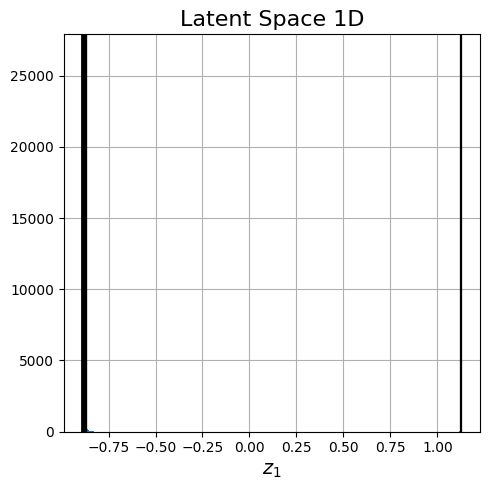

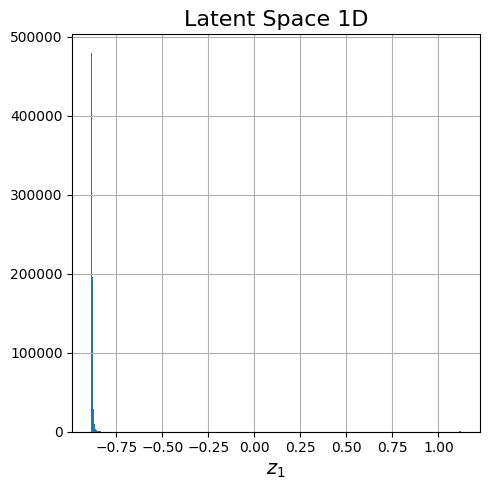

In [70]:
model.encoder.eval()

z = model.encoder(all_data)[::2000]
#z1, z2= normalize_latent_space(z)

z_core = model.encoder(Core_data)
#z1_core, z2_core= normalize_latent_space(z_core)
#plot_latent_2d(z1, z2, coredata = [z1_core,z2_core],filename = 'latent_space_test_data.png')
plot_latent_1d(z_core, coredata = [z],filename = 'latent_space_test_data_1d.png')

z = model.encoder(Initial_data)
#z1, z2= normalize_latent_space(z)
#plot_latent_2d(z1, z2, filename = 'latent_space_Initial_data.png') 
plot_latent_1d(z, filename = 'latent_space_Initial_data_1d.png') 